COPYRIGHT NOTICE
In the name of Christ our Lord be blessed. We, Joshuah Rainstar(joshuah.rainstar@gmail.com), do claim copyright to this code, or software, and associated documentation, as our work in the year 2025 Anno Domini, reserving all rights and assigning them in accordance with the following license terms:

1. Permission is by our authority and with this statement granted, to any person or artificial intelligence without limitation or restriction to examine, analyze, read, dissect, translate, use, modify, and distribute the aforementioned copyrighted items, subject to the following conditions:
2. This license must be included in full with any copies or works containing substantial portions of the copyrighted items.
3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.


THE COPYRIGHTED ITEMS ARE PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE COPYRIGHTED ITEMS OR THEIR USE OR ANY OTHER CIRCUMSTANCES CONCERNING THEM.


this is an experimental model intended to elucidate possible mechanics for attention across sequences in addition to tokenwise. it is reasonably fast and efficient. conceptually, the design was envisioned by me and coded through refinement with OpenAI Codex Orion One and chatgpt. i find that if i cant understand a thing, however clever it is- its wrong.
so, this is largely a from-scratch along aligned principles. 

you are advised in life to apply a similar practice. nothing good comes of shit you dont comprehend.

"hierarchical multi-scale transformer with MoE-like  selection"

my own fucking activation function

my own fucking loss method borrowing from harmonic loss but using student-t distribution 9!

XOR from  Two-argument activation functions learn soft XOR operations like cortical neurons
https://arxiv.org/abs/2110.06871note that my implementation is a differential XOR for backprop capability
motivation: little bit of internal reasoning maybe? Impact: slows down convergence somewhat

WOLF optimizer experimental by me, it may not beat adam but it is simpler than adam, closer to SGD with some smoothing of integration
impact: speeds up convergence somewhat for early iterations and will not NAN from high LR.
probable benefit- switch optimizers after model drops. could be good for bigger models.. maybe

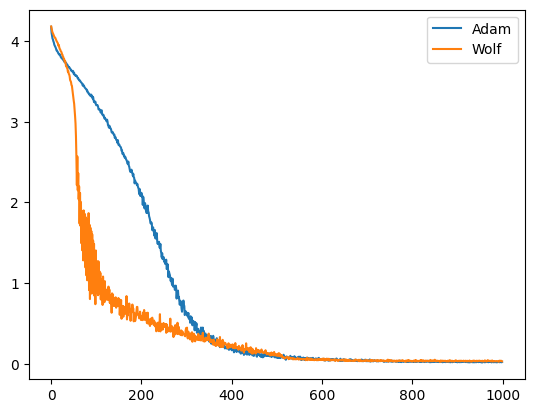
m 

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
import math
import requests

In [21]:
from torch.optim.optimizer import Optimizer
class Wolf(Optimizer):
    """Implements Wolf algorithm."""
    def __init__(self, params, lr=0.25, betas=(0.9, 0.999), eps=1e-8):
        # Define default parameters
        defaults = dict(lr=lr, betas=betas, eps=eps)
        self.lr = lr
        # Initialize the parent Optimizer class first
        super().__init__(params, defaults)
        # Constants specific to Wolf
        # Initialize state for each parameter
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['p'] = torch.zeros_like(p)  # Second moment estimate


    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step and adjusts dropout in transformer blocks."""
        etcerta = 0.367879441  # Constant used in update rule
        et = 1 - etcerta
    
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
    
        # Iterate over parameter groups.
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
    
                #  AMP Compatibility: Check for NaN or Inf in gradients
                if torch.isnan(grad).any() or torch.isinf(grad).any():
                    print("Skipping parameter update due to NaN/Inf gradient.")
                    continue  # Skip this update if the gradient has NaN or Inf
    
                state = self.state[p]
                exp_avg = state['p']
    
                # Compute update and update second moment-like state.
                update = exp_avg * et + grad * etcerta
                state['p'] = exp_avg * et + update * etcerta
    
                # Compute sign agreement between update and gradient.
                sign_agreement = torch.sign(update) * torch.sign(grad)
    
                # Where the signs agree (mask is True), update the parameter.
                mask = (sign_agreement > 0)
                adaptive_alpha = group.get('lr', self.lr)
                p.data = torch.where(mask, p.data - adaptive_alpha * update, p.data)
    
                # AMP Compatibility: Ensure a step counter is updated
                state['step'] = state.get('step', 0) + 1  # Track optimization steps
    
        return loss

# ---------------------------------------------------
# Custom Activation
# ---------------------------------------------------
class ReferenceActivation(nn.Module):
    def __init__(self, gamma=24):
        super().__init__()
        self.gamma = gamma

    def forward(self, x):
        x = torch.clamp(x, -2, 2)
        log_x = torch.sign(x) * torch.log1p(torch.abs(x))
        return log_x / torch.sqrt(1 + self.gamma * log_x ** 2)


class CachedMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1, batch_first=True):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # We use the built-in multihead attention module.
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=batch_first)
    
    def forward(self, query, key, value, past_kv=None):
        """
        query: (B, S_new, D)
        key, value: (B, S_current, D) for the current input tokens.
        past_kv: Tuple (past_key, past_value) or None.
        """
        if not model.training:
            if past_kv is not None:
                past_key, past_value = past_kv
                # Concatenate along the sequence dimension
                key = torch.cat([past_key, key], dim=1)
                value = torch.cat([past_value, value], dim=1)
            # Run the attention module.
            attn_output, attn_weights = self.attn(query, key, value)
            attn_weights_1 = attn_weights.sum(dim=-1)
            attn_weights_2 = attn_weights.sum(dim=-2)
            attn_weights = (attn_weights_1 + attn_weights_2)/2
            # The new cache holds all keys and values computed so far.
            new_kv = (key, value)
            return attn_output, new_kv, attn_weights
        else:
            attn_output,attn_weights = self.attn(query, key, value)
            attn_weights_1 = attn_weights.sum(dim=-1)
            attn_weights_2 = attn_weights.sum(dim=-2)
            attn_weights = (attn_weights_1 + attn_weights_2)/2
            return attn_output, None, attn_weights
            
class RectifiedKAN(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, dropout=0.1):
        super().__init__()
        hidden_dim = expansion_factor * embed_dim

        self.expand = nn.Linear(embed_dim, hidden_dim)  # Expand input
        self.shift = nn.Parameter(torch.zeros(hidden_dim))  # Shift parameters
        self.activation = ReferenceActivation()  # Piecewise linear activation
        self.linear = nn.Linear(hidden_dim, embed_dim)  # Project back
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.expand(x)  # Expand input
        x = x + self.shift  # Apply shift (edge-based transform)
        x = self.activation(x)  # Nonlinear edge activation
        x = self.linear(x)  # Collapse back to original space
        x = self.dropout(x)  # Regularization
        return x


class TapeHeadBlock(nn.Module):
    def __init__(self, chunk_size, seq_len, embed_dim, vocab_size, num_heads=1, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.chunk_size = chunk_size
        self.embed_dim = embed_dim
        self.max_seq_len = seq_len

        # Token embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)

        # Sinusoidal positional embeddings (Precomputed)
        self.register_buffer("pos_emb", self._build_sinusoidal_embedding(seq_len, embed_dim))

        # Rotary embedding setup
        self.use_rope = True  # Set to False to disable RoPE
        if self.use_rope:
            self.register_buffer("rope_freqs", self._build_rope_frequencies(embed_dim))

        # Attention layers
        self.cached_attn = CachedMultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.ln_attn = nn.LayerNorm(embed_dim)

        # MLP and normalization
        self.mlp = RectifiedKAN(embed_dim)
        self.ln_mlp = nn.LayerNorm(embed_dim)

        # Unembedding matrix
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))

        # Logits cross-attention
        self.cached_logits_attn = CachedMultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.placeholder_idx = placeholder_idx

    def _build_sinusoidal_embedding(self, seq_len, embed_dim):
        """Compute sinusoidal positional embeddings"""
        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pos_emb = torch.zeros(seq_len, embed_dim)
        pos_emb[:, 0::2] = torch.sin(position * div_term)
        pos_emb[:, 1::2] = torch.cos(position * div_term)
        return pos_emb.unsqueeze(0)  # Shape: (1, seq_len, embed_dim)


    def _build_rope_frequencies(self, embed_dim):
        """Build the inverse frequency tensor for RoPE and ensure it is a PyTorch tensor."""
        half_dim = embed_dim // 2  # For D=256, half_dim = 128
        base_freqs = 1.0 / (10000 ** (torch.arange(0, half_dim, dtype=torch.float32) / half_dim))
        # Remove the repeat_interleave so we keep shape (half_dim,)
        return base_freqs.to(torch.float32)  # Shape: (D/2,)

        
    def apply_rope(self,tensor, rope_freqs):
            """
            Apply Rotary Positional Embedding (RoPE) to the input tensor.
            
            Args:
                tensor (Tensor): Input tensor of shape (B, S, D), where
                                 B = batch size, S = sequence length, D = embedding dim.
                rope_freqs (Tensor): Frequency tensor of shape (D/2,) computed via _build_rope_frequencies.
                
            Returns:
                Tensor: The input tensor after applying RoPE, with the same shape (B, S, D).
                
            Detailed Steps & Dimensions:
              1. Let B, S, D = tensor.shape and half_dim = D//2.
              2. Compute positions: a tensor of shape (S,).
              3. Compute theta = positions.unsqueeze(1) * rope_freqs.unsqueeze(0)
                 -> theta has shape (S, half_dim).
              4. Compute sin_theta and cos_theta from theta, each of shape (S, half_dim),
                 then expand to (B, S, half_dim).
              5. Split tensor into two halves along the last dimension:
                 - x1 = tensor[..., 0::2] and x2 = tensor[..., 1::2], each with shape (B, S, half_dim).
                 (Alternatively, one can do: x1, x2 = torch.chunk(tensor, 2, dim=-1))
              6. Apply RoPE:
                 - x1_rot = x1 * cos_theta - x2 * sin_theta
                 - x2_rot = x1 * sin_theta + x2 * cos_theta
              7. Reassemble the output by interleaving x1_rot and x2_rot.
            """
            B, S, D = tensor.shape
            assert D % 2 == 0, "Embedding dimension must be even for RoPE."
            half_dim = D // 2  # e.g. for D=256, half_dim = 128
        
            # Ensure rope_freqs is on the same device and dtype as tensor.
            rope_freqs = rope_freqs.to(tensor.device).to(tensor.dtype)  # shape: (half_dim,)
        
            # 1. Compute positions (0, 1, ..., S-1): shape (S,)
            positions = torch.arange(S, device=tensor.device, dtype=tensor.dtype)
            
            # 2. Compute theta = positions * rope_freqs:
            #    positions: (S, 1), rope_freqs: (1, half_dim) --> theta: (S, half_dim)
            theta = positions.unsqueeze(1) * rope_freqs.unsqueeze(0)  # shape: (S, half_dim)
            
            # 3. Compute sin and cos of theta:
            sin_theta = theta.sin()  # shape: (S, half_dim)
            cos_theta = theta.cos()  # shape: (S, half_dim)
            
            # 4. Expand sin and cos to shape (B, S, half_dim)
            sin_theta = sin_theta.unsqueeze(0).expand(B, S, half_dim)
            cos_theta = cos_theta.unsqueeze(0).expand(B, S, half_dim)
            
            # 5. Split tensor into two halves (real and imaginary parts).
            # Here we use alternate slicing: the even-indexed dims are x1, odd-indexed are x2.
            x1 = tensor[..., 0::2]  # shape: (B, S, half_dim)
            x2 = tensor[..., 1::2]  # shape: (B, S, half_dim)
            
            # 6. Apply the RoPE rotation:
            x1_rot = x1 * cos_theta - x2 * sin_theta  # shape: (B, S, half_dim)
            x2_rot = x1 * sin_theta + x2 * cos_theta  # shape: (B, S, half_dim)
            
            # 7. Interleave x1_rot and x2_rot back together.
            # One approach is to create an empty tensor and then fill in even and odd indices.
            out = torch.empty_like(tensor)
            out[..., 0::2] = x1_rot
            out[..., 1::2] = x2_rot
        
            return out


    def forward(self, x, prev_h, prev_emb, logits, past_kv=None):
        """
        x: (B, S) input token IDs
        prev_h: (B, S, D) previous hidden state
        prev_emb: (B, S, D) previous embeddings
        logits: (B, S, V) logits distribution from previous block (can be None)
        past_kv: Dictionary with keys 'chunk_attn' and 'logits_attn' holding KV caches
        """

        past_chunk = past_kv.get('chunk_attn') if past_kv is not None else None
        past_logits = past_kv.get('logits_attn') if past_kv is not None else None

        # Compute token embeddings and add sinusoidal positional embeddings
        seq_len = x.shape[1]
        layer_emb = self.token_emb(x) + self.pos_emb[:, :seq_len, :]

        # Apply RoPE if enabled
        if self.use_rope:
            layer_emb = self.apply_rope(layer_emb, self.rope_freqs)

        # Attention input
        if prev_h is not None:
            attn_input = torch.cat([prev_emb, layer_emb, prev_h[:, -seq_len:, :]], dim=1)
        else:
            attn_input = layer_emb

        # Compute Self-Attention with KV Caching
        if past_chunk is not None:
            attn_out, new_chunk_cache, attn_weights = self.cached_attn(
                attn_input, attn_input, attn_input, past_kv=past_chunk
            )
        else:
            attn_out, _, attn_weights = self.cached_attn(attn_input, attn_input, attn_input)
            new_chunk_cache = None

        h_attn = self.ln_attn(attn_input + attn_out)

        # Compute Logits Cross-Attention with KV Caching
        if logits is not None:
            vocab_embedding = torch.matmul(logits, self.unembedding.T)

            if past_logits is not None:
                logits_context, new_logits_cache, logit_attn_weights = self.cached_logits_attn(
                    h_attn, vocab_embedding, vocab_embedding, past_kv=past_logits
                )
            else:
                logits_context, _, logit_attn_weights = self.cached_logits_attn(
                    h_attn, vocab_embedding, vocab_embedding
                )
                new_logits_cache = None

            h_attn = h_attn + logits_context
        else:
            new_logits_cache = None

        # Pass through MLP
        h_mlp = self.ln_mlp(h_attn + self.mlp(h_attn))

        # Compute final logits
        logits_out = h_mlp @ self.unembedding
        attn_weights = torch.softmax(attn_weights, dim=-1)
        new_cache = None
        # Return KV cache
        if not model.training:
            new_cache = {'chunk_attn': new_chunk_cache, 'logits_attn': new_logits_cache}
        return x, h_mlp, layer_emb, logits_out, new_cache, attn_weights

    


class TapeHead(nn.Module):
    """
    A Transformer-like block with progressive chunk sizes.
    Each layer inside the TapeHead doubles the chunk size.
    """
    def __init__(self, seq_len, embed_dim, vocab_size, num_layers=3, base_chunk=1, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.base_chunk = base_chunk

        # Create progressively larger TapeHeadBlocks for the left and right streams.
        self.blocks_left= nn.ModuleList([
            TapeHeadBlock(
                chunk_size=seq_len,
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_heads=max(1, 2 ** (num_layers - i)),  # Inversely scale heads
                placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for i in range(num_layers)
        ])

        self.blocks_right = nn.ModuleList([
            TapeHeadBlock(
                chunk_size=seq_len,
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_heads=max(1, 2 ** (num_layers - i)),  # Inversely scale heads
                placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for i in range(num_layers)
        ])

        self.activation = nn.Sigmoid()

    def forward(self, x, prev_h, prev_emb, logits, past_kv=None):
        """
        past_kv: dictionary with keys 'left' and 'right', each is a list of caches (one per block).
        """
        attn_weights = []
        if not model.training:
            if past_kv is None:
                past_kv = {'left': [None] * self.num_layers, 'right': [None] * self.num_layers}

            logits_left = logits.clone() if logits is not None else None
            prev_emb_left = prev_emb.clone() if prev_emb is not None else None
            prev_h_left = prev_h.clone() if prev_h is not None else None
    
            new_past_left = []
            new_past_right = []
            
            for i in range(self.num_layers):
                # Process left block with its cache.
                _, h_out_left, layer_emb_left, logits_left, cache_left ,attn_weights_left = self.blocks_left[i](
                    x, prev_h_left, prev_emb_left, logits_left, past_kv=past_kv['left'][i]
                )
                new_past_left.append(cache_left)
                # Process right block with its cache.
                _, h_out, layer_emb, logits, cache_right,attn_weights_right = self.blocks_right[i](
                    x, prev_h, prev_emb, logits, past_kv=past_kv['right'][i]
                )
                new_past_right.append(cache_right)
                attn_weights.append((attn_weights_left+ attn_weights_right)/2.0)

            
            # Combine outputs from left and right streams.
            a = self.activation(h_out_left)
            b = self.activation(h_out)
            h_out = 0.5 * (a + b - 2 * a * b)
            h_out_left = h_out.clone()


        else:
            logits_left = logits.clone() if logits is not None else None
            prev_emb_left = prev_emb.clone() if prev_emb is not None else None
            prev_h_left = prev_h.clone() if prev_h is not None else None
    
            new_past_left = []
            new_past_right = []
            for i in range(self.num_layers):
                # Process left block with its cache.
                _, h_out_left, layer_emb_left, logits_left, _, attn_weights_left = self.blocks_left[i](
                    x, prev_h_left, prev_emb_left, logits_left)

                # Process right block with its cache.
                _, h_out, layer_emb, logits,_, attn_weights_right = self.blocks_right[i](
                    x, prev_h, prev_emb, logits)
                attn_weights.append((attn_weights_left+ attn_weights_right)/2.0)

            
            # Combine outputs from left and right streams.
            a = self.activation(h_out_left)
            b = self.activation(h_out)
            h_out = 0.5 * (a + b - 2 * a * b)
            h_out_left = h_out.clone()
        

        layer_weights = torch.linspace(0.3, 1.0, steps=self.num_layers).to(x.device)  # Increasing importance
        layer_weights /= layer_weights.sum()  # Normalize to sum to 1
        
        attn_weights = torch.stack(attn_weights, dim=0)  # Shape: (num_layers, S, S)

        attn_weights *= layer_weights.view(-1, 1, 1)  # Expand dims to match (num_layers, S, S)
        attn_weights = attn_weights.sum(dim=0)  # Collapse into (S, S)
        # Combine logits and embeddings.
        logits_out = 0.5 * (logits + logits_left - 2 * logits * logits_left)
        layer_emb_out = 0.5 * (layer_emb + layer_emb_left - 2 * layer_emb * layer_emb_left)
        if not model.training:
            new_cache = {'left': new_past_left, 'right': new_past_right}
        else:
            new_cache = None
        return x, h_out, layer_emb_out, logits_out, new_cache, attn_weights

           

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-8):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps

    def forward(self, x):
        return x / (x.norm(2, dim=-1, keepdim=True) + self.eps) * self.weight
        
class TapeTransformer(nn.Module):
    """
    Full GPT-like model with:
      - Token + Position Embeddings
      - Multiple stacked TapeHeads
    """
    def __init__(self, vocab_size, seq_len=128, chunk_len=4, embed_dim=128, num_heads=2, placeholder_idx=None, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.placeholder_idx = placeholder_idx
        self.num_heads = num_heads
        # LayerNorm immediately after embeddings.
        self.embed_ln = nn.LayerNorm(embed_dim)

        # Create a list of TapeHeads.
        self.tape_heads = nn.ModuleList([
            TapeHead(
                seq_len=seq_len,
                embed_dim=embed_dim,
                vocab_size=vocab_size,
                num_layers=math.ceil(math.log2(chunk_len)),
                base_chunk=1,
                placeholder_idx=placeholder_idx,
                dropout=dropout
            )
            for _ in range(num_heads)
        ])
        self.final_norm = RMSNorm(embed_dim)
        self.logits_norm = nn.LayerNorm(embed_dim)
        self.norm_gate = nn.Parameter(torch.tensor(0.5))  # for potential supervisory context
        self.activation = ReferenceActivation()
        # Final unembedding.
        self.logits_weight = nn.Parameter(torch.tensor(0.5))
        self.unembedding = nn.Parameter(torch.randn(embed_dim, vocab_size))
        nn.init.kaiming_uniform_(self.unembedding, a=math.sqrt(5))
        self.merge_projection = nn.Linear(len(self.tape_heads) * embed_dim, embed_dim)

    def forward(self, x, past_kv=None):
        """
        x: (B, S) integer token IDs.
        past_kv: list of caches (one per tape head) or None.
        Returns:
          p_final: (B, S, V) probability distribution,
          new_past_kv: updated caches.
        """
        # Ensure batch dimension.
        x = x.unsqueeze(0) if x.ndim == 1 else x
        B, S = x.shape
        assert S <= self.seq_len, "Sequence too long."

        logits = None
        prev_h = None
        prev_emb = None
        new_past_heads = None
        attn_weights = None
        all_heads_h = []
        if not model.training:
            new_past_heads = []
            if past_kv is None:
                past_kv = [None] * len(self.tape_heads)
    
            # Process each TapeHead.
            for i, head in enumerate(self.tape_heads):
                x, h, prev_emb, logits, head_cache,attn_weights_head = head(x, prev_h, prev_emb, logits, past_kv=past_kv[i])
                new_past_heads.append(head_cache)
                all_heads_h.append(h)
                attn_weights = attn_weights_head if attn_weights is None else attn_weights + attn_weights_head


        else:   
            # Process each TapeHead.
            for i, head in enumerate(self.tape_heads):
                x, n, prev_emb, logits, _, attn_weights_head = head(x, prev_h, prev_emb, logits)
                all_heads_h.append(n)
                attn_weights = attn_weights_head if attn_weights is None else attn_weights + attn_weights_head


        # Merge outputs from all tape heads.
        merged_h = torch.cat(all_heads_h, dim=-1)
        prev_h = self.merge_projection(merged_h)  # (B, S, D)
        attn_weights /= self.num_heads
        # Final logits computed with student-t unembedding.
        p_final = prev_h @ self.unembedding # (B, S, V) #no softmaxing allowed
        return p_final, new_past_heads, attn_weights

In [22]:
import gc,torch

gc.collect()
torch.cuda.empty_cache()

In [23]:
# ====================================================
# Data Preparation (Shakespeare)
# ====================================================
def load_shakespeare_text():
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    text = requests.get(url).text
    return text

text = load_shakespeare_text()
chars = sorted(list(set(text)))

# Add a placeholder token: an ASCII grey block (visible in output)
placeholder = "▒"  # Choose your preferred grey block character
if placeholder not in chars:
    chars.append(placeholder)
    chars.sort()  # Ensure ordering is maintained

vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
placeholder_idx = stoi[placeholder]
print("Placeholder token for even vocab size:", placeholder, "with index:", placeholder_idx)


def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(batch_size, seq_len):
    ix = torch.randint(0, data.size(0) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y
    

# ====================================================
# Training Setup
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TapeTransformer(
    vocab_size=vocab_size,  # example
    seq_len=128,#longer not truly needed beause we KV cache
    chunk_len=4,
    embed_dim=256,#heads times true vocab, round up 
    num_heads=8,
    placeholder_idx=placeholder_idx,
    dropout=0 #cannot use dropout, tooo slow
).to(device)

optimizer = Wolf(model.parameters(), lr=0.3678)

scaler = GradScaler()

num_epochs = 100
batch_size = 16
eps = 1e-8

loss_history = []


Placeholder token for even vocab size: ▒ with index: 65


In [5]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

35350530

In [39]:
optimizer = Wolf(model.parameters(), lr=0.3678)


In [40]:
import torch
import math
from collections import deque


# Training control variables
seq_len = 128  # Start with the smallest sequence
max_seq_len = 128
batch_size = 16


# Loss tracking
epochs_per_check = 10  # Print every 10 epochs
target_loss = max(math.log(vocab_size/(seq_len+1)),0)

In [33]:
# Adjusted Code to Improve EWMA Size and Implement Loss Ticker as a Moving Graph

import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

# --- Configuration Constants ---
CHAR_WIDTH = 8  # Font size 8 for token rendering
CHAR_HEIGHT = 11
SEQ_LEN = 128
BATCH_SIZE = 16
LOSS_BAR_HEIGHT = 32
EWMA_HEIGHT = 32  # Increased to accommodate large text (previously 32)

# Full-resolution framebuffer dimensions
container_width = CHAR_WIDTH * SEQ_LEN  # 1024 pixels
container_height = CHAR_HEIGHT * BATCH_SIZE  # 176 pixels
total_height = container_height + LOSS_BAR_HEIGHT + EWMA_HEIGHT  # Adjusted for larger EWMA

# Final scaled-down dimensions
scaled_width = container_width   # 512 pixels
scaled_height = total_height  # 170 pixels

# Initialize framebuffer
framebuffer = np.zeros((total_height, container_width, 3), dtype=np.uint8)

# EWMA storage
loss_history = []
ticker_history = np.zeros(SEQ_LEN, dtype=np.float32)  # Stock ticker moving buffer

# Load font
try:
    font = ImageFont.truetype("DejaVuSansMono.ttf", 8)  # Monospaced font
    font_large = ImageFont.truetype("DejaVuSansMono.ttf", 64)  # Large EWMA display
except:
    font = ImageFont.load_default()
    font_large = font

# --- Color Mapping Functions ---
def get_flame_color(val):
    """Map a normalized value to a flame-like color."""
    return np.array([int(val * 255), int(val * 0.5 * 255), 0], dtype=np.uint8)

def get_ewma_color(val):
    """Map a normalized loss value to a dark-blue-to-white scale."""
    scale = np.log(1 + val * 64) / np.log(65)  # Normalize using ln(65)
    return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)

# --- IPython Display Setup ---
out = widgets.Output()
display(out)

# --- Framebuffer Update Function ---
def update_framebuffer(attn_torch, losses_torch, current_loss, tokens):
    attn_weights = torch.softmax(attn_torch, dim=-1).cpu().detach().numpy()
    token_losses =losses_torch.cpu().detach().numpy()

    """Render the text grid with coloration based on attn * inverse loss."""
    global framebuffer, loss_history, ticker_history

    # Compute attention * inverse loss
    intensity = attn_weights * (1 - token_losses)  # (BATCH_SIZE, SEQ_LEN)

    # Normalize to [0,1]
    intensity = (intensity - intensity.min()) / (intensity.max() + 1e-6)

    # Create image buffer
    img = Image.new("RGB", (container_width, total_height), (0, 0, 0))
    draw = ImageDraw.Draw(img)

    # Render text with colored intensity
    for row in range(BATCH_SIZE):
        for col in range(SEQ_LEN):
            char = tokens[row][col]
            color = tuple(get_flame_color(intensity[row, col]))
            x, y = col * CHAR_WIDTH, row * CHAR_HEIGHT + EWMA_HEIGHT + LOSS_BAR_HEIGHT
            draw.text((x, y), char, font=font, fill=color)

    # --- EWMA Display (LARGE FONT) ---
    loss_history.append(current_loss.item())
    if len(loss_history) > 128:
        loss_history.pop(0)
    ewma = np.exp(np.convolve(np.log(np.array(loss_history) + 1e-6), np.ones(128) / 128, mode='valid'))[-1]
    ewma_text = f"{ewma:.4f}"
    ewma_color = tuple(get_ewma_color(ewma))
    draw.text((container_width-128, 0), ewma_text, font_size=32, fill=ewma_color)

    # --- Moving Loss Ticker Graph ---
    ticker_history = np.roll(ticker_history, -1)  # Shift left
    ticker_history[-1] = current_loss.item()  # Insert new loss on the right

    # Rescale ticker dynamically like a stock ticker (normalize to min-max range)
    min_loss = np.min(ticker_history)
    max_loss = np.max(ticker_history)
    range_loss = max_loss - min_loss if max_loss != min_loss else 1
    normalized_ticker = (ticker_history - min_loss) / range_loss

    # Draw ticker graph line
    for i in range(SEQ_LEN - 1):
        x1, y1 = i * CHAR_WIDTH, EWMA_HEIGHT + int((1 - normalized_ticker[i]) * LOSS_BAR_HEIGHT)
        x2, y2 = (i + 1) * CHAR_WIDTH, EWMA_HEIGHT + int((1 - normalized_ticker[i + 1]) * LOSS_BAR_HEIGHT)
        draw.line([(x1, y1), (x2, y2)], fill=(0, 255, 255), width=2)

    # Convert to numpy array
    framebuffer = np.array(img)

# --- IPython Display Update Function ---
def update_display():
    """Show the framebuffer, scaled down by half using ipywidgets."""
    img = Image.fromarray(framebuffer)
    img_resized = img.resize((scaled_width, scaled_height), Image.LANCZOS)
    
    with out:
        clear_output(wait=True)
        display(img_resized)



Output()

In [ ]:
# Training loop for current sequence length
for epoch in range(100000):
    model.train()
    x_batch, targets = get_batch(batch_size, 128)
    x_batch, targets = x_batch.to(device), targets.to(device)
    optimizer.zero_grad()

    with torch.cuda.amp.autocast():
        preds, _, attn_weights = model(x_batch)

        # Decode token indices back to characters
        tokens = [[itos[idx] for idx in seq.tolist()] for seq in x_batch]
        
        # Convert logits to log probabilities
        log_probs = torch.log_softmax(preds, dim=-1)  # Softmax AFTER matrix multiplication
        # Gather log probabilities of the correct tokens
        gathered_log_probs = torch.gather(log_probs, -1, targets.unsqueeze(-1)).squeeze(-1)

        # Compute per-token loss (neg log probs) and final loss
        weighted_loss = -gathered_log_probs  # Shape: (batch_size, seq_len)
        final_loss = weighted_loss.mean()
        
    update_framebuffer(attn_weights, gathered_log_probs, final_loss, tokens)
    update_display()
    scaler.scale(final_loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()

    # Track loss & progress
    loss_val = final_loss.item()
    loss_history.append(loss_val)

    # Update framebuffer visualization with real model outputs
  

    print(f"Epoch {epoch}, Loss: {loss_val:.6f}")




Epoch 0, Loss: 4.206007


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 256 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 1, Loss: 3.872540


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 258 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 2, Loss: 3.660532


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 259 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 3, Loss: 3.549589


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 260 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 4, Loss: 3.360060


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 261 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 5, Loss: 3.464339


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 262 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 6, Loss: 3.350495


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 264 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 7, Loss: 3.368845


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 265 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 8, Loss: 3.359169


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 266 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 9, Loss: 3.383101


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 267 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


Epoch 10, Loss: 3.327113


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14708\1737069180.py:50: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 268 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  return np.array([int(scale * 255), int(scale * 255), 255], dtype=np.uint8)


In [27]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

35350530

In [ ]:
import matplotlib.pyplot as plt

logit_list = []  # Store raw logits
prob_list = []  # Store softmax probabilities

model.eval()
past_kv = None  # Initialize cache for the entire model.
with torch.no_grad():
    prompt = "oh Romeo! Romeo!"
    context = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    generated = context
    for _ in range(200):  # Generate 200 tokens.
        inp = generated[:, -1:]  # Only use the last token.
        p, past_kv, attn_weights = model(inp, past_kv=past_kv)  # Forward pass with cache.

        last_token_logits = p[:, -1, :].cpu().numpy().flatten()  # Get raw logits
        logit_list.append(last_token_logits)

        temperature = 0.7  # Lower = more deterministic, Higher = more diverse (0.7–1.0 is good)
        last_token_probs = torch.softmax(p[:, -1, :] / temperature, dim=-1).cpu().numpy().flatten()
        prob_list.append(last_token_probs)

        predicted_token = torch.multinomial(torch.tensor(last_token_probs), num_samples=1).unsqueeze(0)  # Fix shape
        generated = torch.cat((generated, predicted_token.to(device)), dim=1)  # Concatenate properly

    sample = decode(generated[0].cpu().tolist())
    print("Generated Sample:\n", sample)

# Plot histograms of logits and probabilities
plt.figure(figsize=(12, 5))

# Plot logits histogram
plt.subplot(1, 2, 1)
plt.hist(logit_list[-1], bins=100, alpha=0.75)
plt.title("Logits Distribution (Before Softmax)")
plt.xlabel("Logit Value")
plt.ylabel("Frequency")

# Plot probabilities histogram
plt.subplot(1, 2, 2)
plt.hist(prob_list[-1], bins=100, alpha=0.75)
plt.title("Probabilities Distribution (After Softmax)")
plt.xlabel("Probability Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [101]:
save_path = 'model_dict.pth'

# Save the model's state_dict
torch.save(model.state_dict(), save_path)


In [5]:
save_path = 'model_dict.pth'

# Save the model's state_dict
state_dict = torch.load(save_path)
model.load_state_dict(state_dict)


<All keys matched successfully>

In [236]:
torch.save(model, "full_model_structure_216_225.pth")

In [16]:
optimizer = Wolf(model.parameters(), lr=0.3678)


In [9]:
from matplotlib import pyplot as plt

In [10]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

35350530

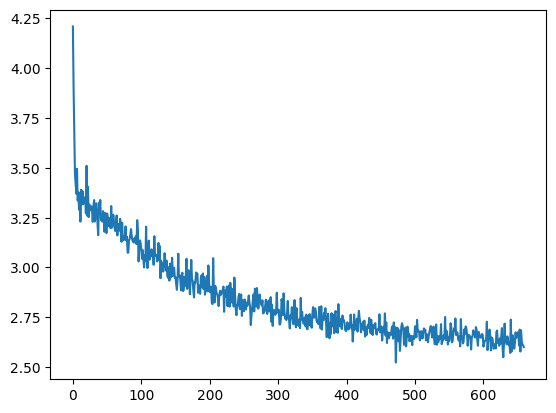

In [11]:
plt.plot(loss_history)